# SHAP
Mithilfe von SHAP soll untersucht werden:

- Welche Bildbereiche das Modell für die Klassifikation heranzieht.
- Ob sich die wichtigen Merkmale je nach Pokémon-Klasse unterscheiden.
- Wie sich die Modellentscheidungen bei gezielter Manipulation der Pokemons ändern.

### Funktionsweise von SHAP
SHAP berechnet Shapley-Werte, um den Einfluss einzelner Eingabe-Features auf die Modellvorhersage zu bewerten. Für Bilder identifiziert SHAP, welche Pixel oder Regionen am wichtigsten für eine Entscheidung sind. Dazu werden Bildbereiche maskiert und der Effekt auf die Vorhersage wird analysiert.

In diesem Projekt wurde der "blur"-Masker gewählt, der maskierte Bildbereiche durch unscharfe Versionen ersetzt. Dies ermöglicht eine natürliche Verzerrung der Bilder und bewahrt damit wichtige Strukturen.

## Initialisierung von SHAP
Importieren der benötigten Libraries

In [1]:
import numpy as np
from datasets import load_dataset
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import shap
import requests
from io import BytesIO
import tensorflow as tf

c:\Users\manue\Documents\GitHub\xai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trainiertes modell und datensatz laden

In [2]:
model = load_model('model_0.781.keras')
dataset = load_dataset("keremberke/pokemon-classification", 'full', split="train")

SHAP explainer

In [3]:
target_size = (160, 160)
image_shape = (160, 160, 3) 

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(32,32)", image_shape)

num_classes = len(dataset.features['labels'].names)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(num_classes)))

Hilfsfunktionen

Die Funktion analyze_image_url() führt folgende Schritte aus:
- Preprocessing des Bildes.
- Modellvorhersage des Bildes.
- Berechnung und Visualisierung der SHAP-Werte.


In [4]:
image_folder = "samples/"

# Bild preprocessing
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Bild analysieren
def analyze_image(image_name):
    x_test_sample = preprocess_image(image_folder + image_name, target_size)
    
    prediction = model(np.array([x_test_sample]))
    prediction_probabilities = tf.nn.softmax(prediction).numpy()
    predicted_class_idx = np.argmax(prediction_probabilities, axis=-1)[0]
    predicted_class_name = sorted(dataset.features['labels'].names)[predicted_class_idx]
    print(f"Model Prediction: {predicted_class_name} (Class Index: {predicted_class_idx})")

    shap_values_ = explainer(np.array([x_test_sample]), max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values_)

## Analyse des Modells
### Pikachu

In [ ]:
analyze_image("pikachu.jpg")

Model Prediction: Pikachu (Class Index: 102)


 57%|█████▋    | 1142/1998 [00:06<00:08, 102.27it/s]

Hier ist deutlich zu erkennen das die wichtigte Eigenschaft für das Modell die roten Backen des Pikachus sind. Daher soll nun geprüft werden wie es sich verhält wenn diese nicht mehr vorhanden sind.

In [ ]:
analyze_image("pikachu_no_cheeks.jpg")

Model Prediction: Pikachu (Class Index: 102)


Entgegen der Annahme wird Pikachu immer noch korrekt erkannt. Stattdesssen fokussiert sich das Modell jetzt auf die Ohren. Zu beachten ist aber auch der niedrigere SHAP wert zu dem Plot davor.
Als nächstes soll daher ein Bild ohne Ohren und Schwanz getestet werden.

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:22, 22.22s/it]               


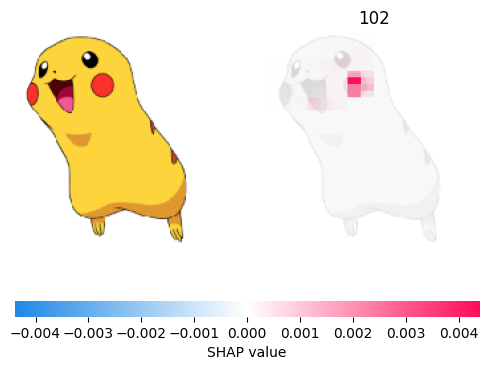

In [ ]:
analyze_image("pikachu_no_ears.png")

Wie erwartet ist der Fokus nun wieder auf den Roten backen. Diese scheinen also auschlaggebender zu sein als der eigentlich sehr charakteristische Schwanz oder die Ohren, sodass das Modell trotzdem auf Pikachu schließt.

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:22, 22.03s/it]               


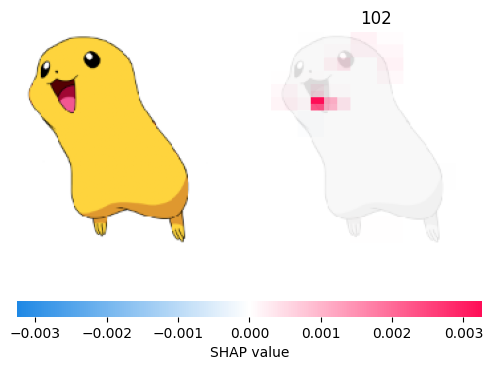

In [ ]:
analyze_image("pikachu_no_cheeks_ears.png")

Auch ohne die roten backen wird Pikachu aber noch korrekt erkannt. Hierbei liegt der Fokus auf dem Mund.
Dem Modell scheint es daher vor allem um die rote Farbe zu gehen. Als letzter Test soll auch dieses Merkmal genommen werden.

Model Prediction: Psyduck (Class Index: 110)


PartitionExplainer explainer: 2it [00:21, 21.50s/it]               


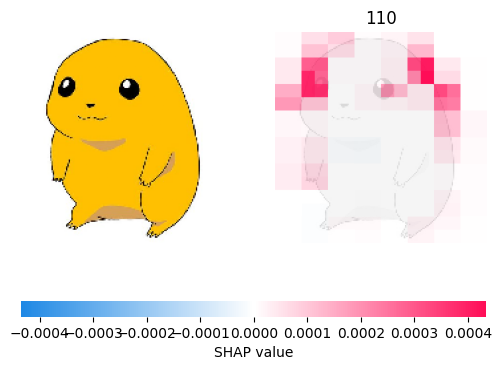

In [ ]:
analyze_image("pikachu_nothing.jpg")

Wie erwartet wird Pikachu nun nicht mehr erkannt. Das Wegnehmen aller charakteristischen Merkmale führt dazu, dass das Modell keine korrekte Zuordnung mehr treffen kann.

Die Analyse der verschiedenen Pikachu-Bilder zeigt, dass das Modell stark auf die roten Backen fokussiert ist. Selbst wenn andere charakteristische Merkmale wie Ohren oder Schwanz entfernt werden, bleibt die Klassifikation korrekt, solange die roten Backen vorhanden sind. Interessant ist aber die verschiebung der fokussierung auf andere Merkmale, sobald ein Merkmal, in diesem Fall die Backen, weggenommen wird.

### Hitmonchan

Model Prediction: Hitmonchan (Class Index: 53)


PartitionExplainer explainer: 2it [00:21, 21.45s/it]               


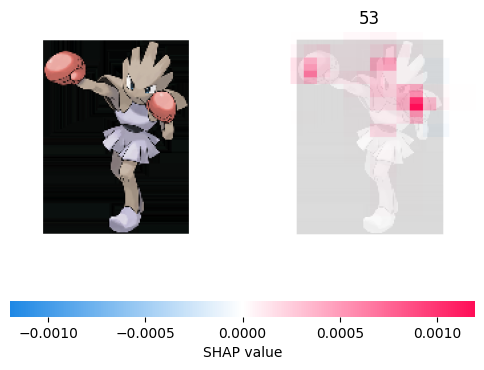

In [ ]:
analyze_image("hitmonchan.png")

Bei der Analyse von Hitmonchan wird deutlich, das hier die roten Boxhandschuhe als deutlichstes Merkmal gewertet werden. Dies soll mit dem nächsten Bild noch bestätigt werden. 

Model Prediction: Hitmonchan (Class Index: 53)


PartitionExplainer explainer: 2it [00:20, 20.98s/it]               


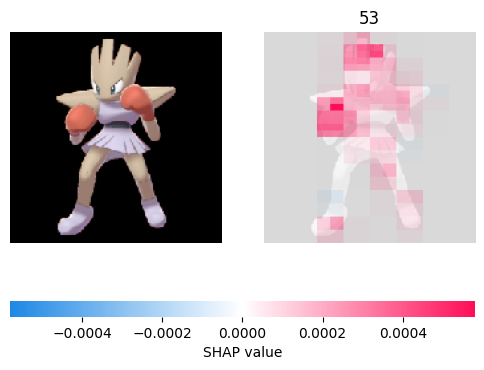

In [ ]:
analyze_image("hitmonchan2.png")

Trotz einem verschwommenerem Fokus ist dieser noch zum größten Teil auf dem roten Boxhandschuh.
Daher soll nun getestet werden was passiert wenn Farbe dieser geändert wird.

Model Prediction: Mew (Class Index: 82)


PartitionExplainer explainer: 2it [00:21, 21.05s/it]               


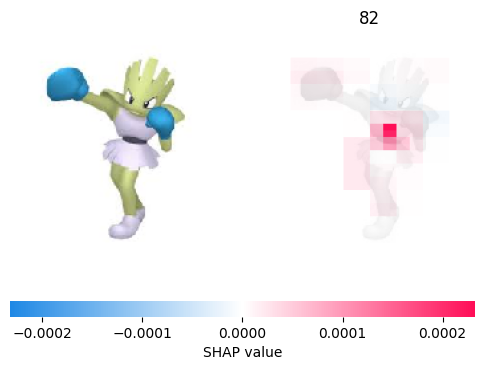

In [ ]:
analyze_image("hitmonchan_blue.jpeg")

Tatsächlich reicht diese Änderung aus um dem Modell das wichtigste Merkmal des Pokemons zu nehmen und dadurch eine korrekte Erkennung zu verhindern.

### Gengar

Model Prediction: Gengar (Class Index: 41)


PartitionExplainer explainer: 2it [00:22, 22.90s/it]               


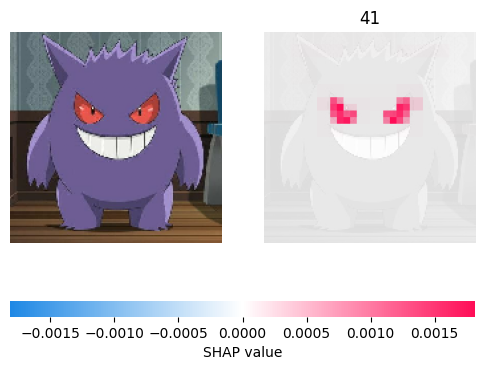

In [ ]:
analyze_image("660a1122583033a20cf90ce9dccbe2c2.jpg")

Hier ist ein sehr deutlicher Fokus auf die roten Augen zu erkennen. Im nächsten Bild soll daher Gengar mit geschlossenen Augen getestet werden.

Model Prediction: Muk (Class Index: 86)


PartitionExplainer explainer: 2it [00:22, 22.01s/it]               


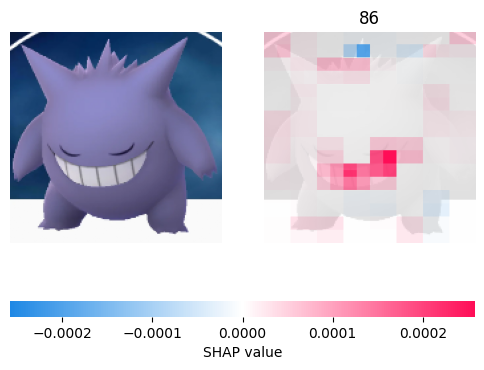

In [ ]:
analyze_image("rhw55lui8dz21.webp")

Tatsächlich reichen hier die geschlossenen Augen aus um ein falsches Resultat zu bekommen. 
Im gegensatz zu Pikachu haben hier also die anderen Merkmale, wie beispielsweise die eigentlich auch sehr charakteristischen Ohren, einen geringen Stellenwert.
Dies ist damit zu erklären, dass der Datensatz zu Gengar fast auschließlich aus Bildern mit den Roten Augen besteht.

## Quellenangaben
- Ukwuoma, C. C., Cai, D., Eziefuna, E. O., Oluwasanmi, A., Abdi, S. F., Muoka, G. W., Thomas, D., & Sarpong, K. (2025). Enhancing histopathological medical image classification for early cancer diagnosis using deep learning and explainable AI – LIME & SHAP. Biomedical Signal Processing and Control, 100(Part C), 107014. https://doi.org/10.1016/j.bspc.2024.107014
- den Broeck,  G. V.;  Lykov,  A.;  Schleich,  M.;  and Suciu,  D. 2022.  On the Tractability ofSHAP Explanations.J. Artif. Intell. Res.74:  851–886. https://doi.org/10.1613/jair.1.13283.2
- Oveis, M. (2024, January 26). Easy guide: Using SHAP algorithm to explain CNN classification of SAR images (MSTAR database). Medium. https://medium.com/@oveis/easy-guide-using-shap-algorithm-to-explain-cnn-classification-of-sar-images-mstar-database-8138657585c8